Lambda School Data Science

*Unit 4, Sprint 3, Module 3*

---

# Autoencoders

> An autoencoder is a type of artificial neural network used to learn efficient data codings in an unsupervised manner.[1][2] The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for dimensionality reduction, by training the network to ignore signal “noise”. Along with the reduction side, a reconstructing side is learnt, where the autoencoder tries to generate from the reduced encoding a representation as close as possible to its original input, hence its name. 

## Learning Objectives
*At the end of the lecture you should be to*:
* <a href="#p1">Part 1</a>: Describe the componenets of an autoencoder
* <a href="#p2">Part 2</a>: Train an autoencoder
* <a href="#p3">Part 3</a>: Apply an autoenocder to a basic information retrieval problem

__Problem:__ Is it possible to automatically represent an image as a fixed-sized vector even if it isn’t labeled?

__Solution:__ Use an autoencoder

Why do we need to represent an image as a fixed-sized vector do you ask? 

* __Information Retrieval__
    - [Reverse Image Search](https://en.wikipedia.org/wiki/Reverse_image_search)
    - [Recommendation Systems - Content Based Filtering](https://en.wikipedia.org/wiki/Recommender_system#Content-based_filtering)
* __Dimensionality Reduction__
    - [Feature Extraction](https://www.kaggle.com/c/vsb-power-line-fault-detection/discussion/78285)
    - [Manifold Learning](https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction)

We've already seen *representation learning* when we talked about word embedding modelings during our NLP week. Today we're going to achieve a similiar goal on images using *autoencoders*. An autoencoder is a neural network that is trained to attempt to copy its input to its output. Usually they are restricted in ways that allow them to copy only approximately. The model often learns useful properties of the data, because it is forced to prioritize which aspecs of the input should be copied. The properties of autoencoders have made them an important part of modern generative modeling approaches. Consider autoencoders a special case of feed-forward networks (the kind we've been studying); backpropagation and gradient descent still work. 

# Autoencoder Architecture (Learn)
<a id="p1"></a>

## Overview

The *encoder* compresses the input data and the *decoder* does the reverse to produce the uncompressed version of the data to create a reconstruction of the input as accurately as possible:

<img src='https://miro.medium.com/max/1400/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png' width=800/>

The learning process gis described simply as minimizing a loss function: 
$ L(x, g(f(x))) $

- $L$ is a loss function penalizing $g(f(x))$ for being dissimiliar from $x$ (such as mean squared error)
- $f$ is the encoder function
- $g$ is the decoder function

## Follow Along
### Extremely Simple Autoencoder

In [1]:
import tensorflow as tf
import numpy as np
import os
%load_ext tensorboard

# needed to update link
# use this link, here -- it works! 
URL_ = "https://github.com/LambdaSchool/DS-Unit-4-Sprint-2-Neural-Networks/blob/main/quickdraw10.npz?raw=true"

# create directory to store images that we'll we will be using to train out auto-encoders 
path_to_zip = tf.keras.utils.get_file('./quickdraw10.npz', origin=URL_, extract=False)

25427968/25421363 [==============================] - 0s 0us/step


In [2]:
data = np.load(path_to_zip)

x_train = data['arr_0']
y_train = data['arr_1']

print(x_train.shape)
print(y_train.shape)

(100000, 784)
(100000,)


In [3]:
class_names = ['apple',
 'anvil',
 'airplane',
 'banana',
 'The Eiffel Tower',
 'The Mona Lisa',
 'The Great Wall of China',
 'alarm clock',
 'ant',
 'asparagus']

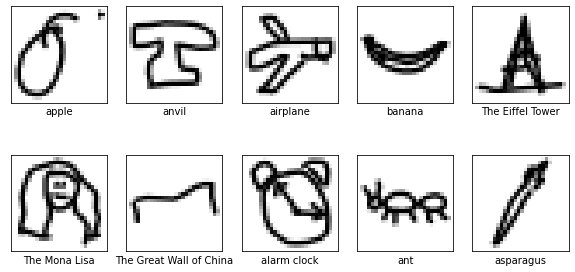

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
start = 0

# helper function used to plot images 
for num, name in enumerate(class_names):
    plt.subplot(2,5, num+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[start].reshape(28,28), cmap=plt.cm.binary)
    plt.xlabel(name)
    start += 10000
plt.show()

In [5]:
from sklearn.utils import shuffle
# also a good idea to suffice data before using it to build a model
x_train, y_train = shuffle(x_train, y_train)

In [6]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [7]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

### very simple auto-encoder model to reconstruct images ###

# YOUR CODE HERE
# raise NotImplementedError()

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)
encoder.summary()


# autoencoder.compile(optimizer='nadam', loss='binary_crossentropy')
# autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
Total params: 25,120
Trainable params: 25,120
Non-trainable params: 0
_________________________________________________________________


In [8]:
autoencoder.compile(optimizer='nadam', loss='binary_crossentropy')

In [9]:
# we are scaling the pixel values between 0 and 1 by dividing by the largest pixel value (i.e. 255)
max_pixel_value = 255
x_train = x_train.astype('float32') / max_pixel_value
print(x_train.shape)

(100000, 784)


In [10]:
import os
import datetime

from tensorflow.keras.callbacks import TensorBoard
# tf.keras.callbacks.TesnorBoard()

# cut off training if loss doesn't decrease by a certain amount over X number of epoches 
stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=2)
now = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

logdir = os.path.join("logs", f"SimpleAutoencoder-{now}")
tensorboard = TensorBoard(log_dir=logdir)

autoencoder.fit(x_train, # input image to encoder
                x_train, # provide input image to decoder so the model learns how to reconstruct the input image 
                epochs=100,
                batch_size=64,
                shuffle=True,
                validation_split=.2,
                verbose = True,
                callbacks=[stop, tensorboard])

Epoch 1/100
1250/1250 [==============================] - 7s 3ms/step - loss: 0.2942 - val_loss: 0.2422
Epoch 2/100
1250/1250 [==============================] - 3s 3ms/step - loss: 0.2331 - val_loss: 0.2273
Epoch 3/100
1250/1250 [==============================] - 3s 3ms/step - loss: 0.2257 - val_loss: 0.2239
Epoch 4/100
1250/1250 [==============================] - 3s 3ms/step - loss: 0.2237 - val_loss: 0.2229
Epoch 5/100
1250/1250 [==============================] - 3s 2ms/step - loss: 0.2228 - val_loss: 0.2222
Epoch 6/100
1250/1250 [==============================] - 3s 3ms/step - loss: 0.2223 - val_loss: 0.2218
Epoch 7/100
1250/1250 [==============================] - 3s 2ms/step - loss: 0.2219 - val_loss: 0.2217
Epoch 8/100
1250/1250 [==============================] - 3s 2ms/step - loss: 0.2217 - val_loss: 0.2213


In [11]:
#%tensorboard --logdir ./logs

In [12]:
# encode and decode some images
# original images go in (i.e, x_train) and decoded images come out (i.e. a non-perfect reconstruction of x_train)
decoded_imgs = autoencoder(x_train)

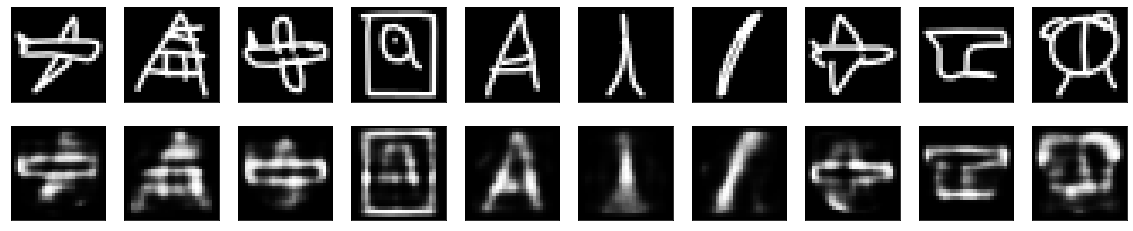

In [13]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

### helper fuction for plotting reconstructed and original images 
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Challenge

Expected to talk about the components of autoencoder and their purpose. 

# Train an Autoencoder (Learn)
<a id="p2"></a>

## Overview

As long as our architecture maintains an hourglass shape, we can continue to add layers and create a deeper network. 

## Follow Along

### Deep Autoencoder

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_6 (Dense)              (None, 256)               16640     
_________________________________________________________________
dense_7 (Dense)              (None, 784)               2014

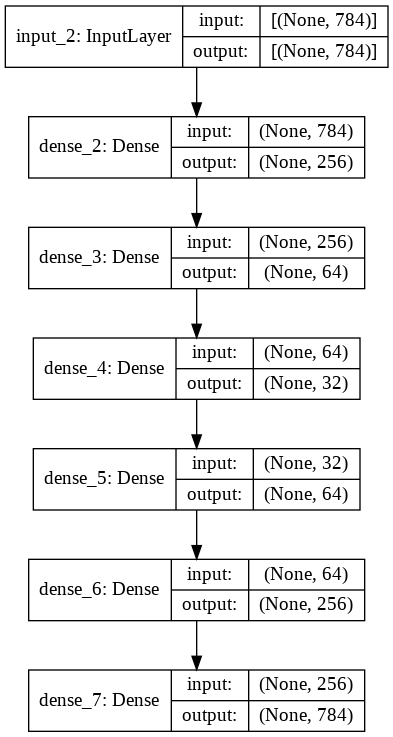

In [14]:
# input layer 
input_img = Input(shape=(784,))

#                                encoder     ->    decoder 
# dim of each hidden layer: 748, 128, 64, 32 -> 64, 128, 784

# YOUR CODE HERE
# raise NotImplementedError()
encoded_1 = Dense(256, activation='relu')(input_img)
encoded_2 = Dense(64, activation='relu')(encoded_1)

# Latent Representation 
encoded = Dense(32, activation='relu')(encoded_2)

# Decoder
decoder_1 = Dense(64, activation='relu')(encoded)
decoder_2 = Dense(256, activation='relu')(decoder_1)
decoder = Dense(784, activation='sigmoid')(decoder_2)

autoencoder = Model(input_img, decoder)
autoencoder.summary()


# Extra
from tensorflow.keras.utils import plot_model
plot_model(autoencoder, show_shapes=True)

In [15]:
# compile & fit model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import os
import datetime

autoencoder.compile(optimizer='nadam', loss='binary_crossentropy')

from tensorflow.keras.callbacks import TensorBoard
# tf.keras.callbacks.TesnorBoard()

stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5)
now = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

logdir = os.path.join("logs", f"DeepAutoencoder-{now}")
tensorboard = TensorBoard(log_dir=logdir)

autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=64,
                shuffle=True,
                validation_split=.2,
                verbose = True,
                callbacks=[stop, tensorboard])

Epoch 1/10
1250/1250 [==============================] - 6s 4ms/step - loss: 0.2743 - val_loss: 0.2406
Epoch 2/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.2314 - val_loss: 0.2232
Epoch 3/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.2184 - val_loss: 0.2124
Epoch 4/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.2099 - val_loss: 0.2071
Epoch 5/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.2039 - val_loss: 0.2011
Epoch 6/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1990 - val_loss: 0.1972
Epoch 7/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1956 - val_loss: 0.1956
Epoch 8/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1930 - val_loss: 0.1925
Epoch 9/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1911 - val_loss: 0.1905
Epoch 10/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.189

In [16]:
decoded_imgs = autoencoder.predict(x_train)

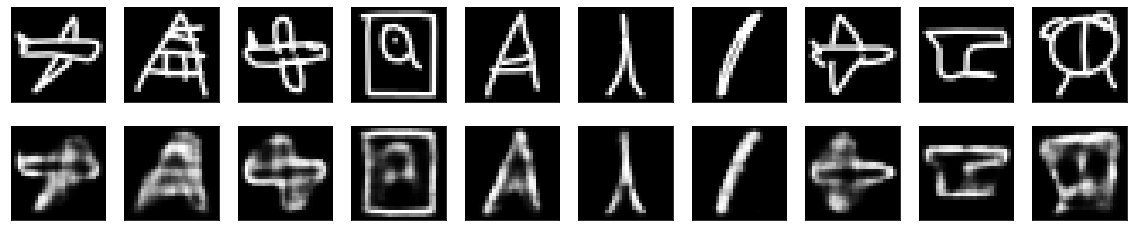

In [17]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Convolutional autoencoder

> Since our inputs are images, it makes sense to use convolutional neural networks (convnets) as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders --they simply perform much better.

> Let's implement one. The encoder will consist in a stack of Conv2D and MaxPooling2D layers (max pooling being used for spatial down-sampling), while the decoder will consist in a stack of Conv2D and UpSampling2D layers.

In [18]:
x_train = x_train.reshape((x_train.shape[0], 28, 28))

In [19]:
x_train.shape

(100000, 28, 28)

In [20]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

# YOUR CODE HERE
# raise NotImplementedError()

# Create Model 
input_img = Input(shape=(28, 28, 1))

x = Conv2D(16, (3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(2, (3, 3), activation='relu', padding='same')(x)

# Latent Representation is (4, 4, 2) i.e. 32-dimensional representation
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(2, (3,3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2,2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='nadam', 
                    loss='binary_crossentropy')
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 2)           146       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 2)           0   

In [ ]:
# compile & fit model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import os
import datetime

autoencoder.compile(optimizer='nadam', loss='binary_crossentropy')

from tensorflow.keras.callbacks import TensorBoard
# tf.keras.callbacks.TesnorBoard()

stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5)
now = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

logdir = os.path.join("logs", f"ConvolutionalAutoencoder-{now}")
tensorboard = TensorBoard(log_dir=logdir)

autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=32,
                shuffle=True,
                validation_split=.2,
                verbose = True,
                callbacks=[stop, tensorboard])

Epoch 1/10
2500/2500 [==============================] - 44s 6ms/step - loss: 0.2885 - val_loss: 0.2613
Epoch 2/10
2500/2500 [==============================] - 14s 6ms/step - loss: 0.2566 - val_loss: 0.2509
Epoch 3/10
2500/2500 [==============================] - 14s 6ms/step - loss: 0.2478 - val_loss: 0.2433
Epoch 4/10
2500/2500 [==============================] - 14s 6ms/step - loss: 0.2417 - val_loss: 0.2375
Epoch 5/10
2500/2500 [==============================] - 14s 6ms/step - loss: 0.2360 - val_loss: 0.2323
Epoch 6/10
2500/2500 [==============================] - 14s 6ms/step - loss: 0.2313 - val_loss: 0.2298
Epoch 7/10
2500/2500 [==============================] - 15s 6ms/step - loss: 0.2290 - val_loss: 0.2269
Epoch 8/10
2500/2500 [==============================] - 14s 6ms/step - loss: 0.2273 - val_loss: 0.2257
Epoch 9/10
2500/2500 [==============================] - 14s 6ms/step - loss: 0.2262 - val_loss: 0.2246
Epoch 10/10
2500/2500 [==============================] - 14s 6ms/step - l

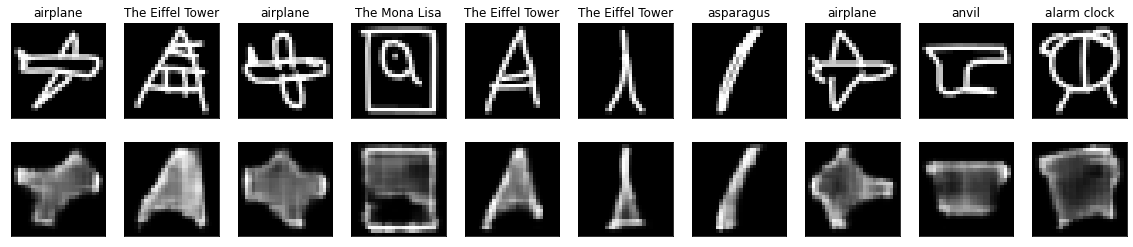

In [ ]:
import matplotlib.pyplot as plt

decoded_imgs = autoencoder.predict(x_train)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_train[i])
    plt.title(class_names[y_train[i]])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
#%load_ext tensorboard

In [ ]:
#%tensorboard --logdir ./logs

#### Visualization of the Representations

In [ ]:
# we have isolated the encoder portion of our auto-encoder so that we can access the encoder vector (i.e. the output of the encoder)
encoder = Model(input_img, encoded)

# the predictions (i.e. the output) of our encoder model are the original images encoder into a smaller dim space (i.e. the encoder vectors)
encoded_imgs = encoder.predict(x_train)

n = 10
plt.figure(figsize=(20, 8))
for i in range(1, n):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i].reshape(4, 4 * 2).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


# these images are the encoded vectors for some of the images in the x_train
# notice that we really can't interpret them, this is the price we pay for non-linear dimentionality reduction
# the features in the encoded vectors are non-linear combinations of the input features
# this is the same give and take that we make with PCA - which is linear dimentionality reduction
# here's the link for the cool interactive visual for PCA that I used in class: https://setosa.io/ev/principal-component-analysis/

In [ ]:
x_train.shape

In [ ]:
# (num of images, height, width, num of feature maps)
# remember that feature maps are the result of convolutions 
encoded_imgs.shape

## Challenge

You will train an autoencoder at some point in the near future. 

# Information Retrieval with Autoencoders (Learn)
<a id="p3"></a>

## Overview

A common usecase for autoencoders is for reverse image search. Let's try to draw an image and see what's most similiar in our dataset. 

To accomplish this we will need to slice our autoendoer in half to extract our reduced features. :) 

## Follow Along

We are going to perform the following: 

- Build an encoder model
- Train a NearestNeighbors on encoded images
- Choose a query image 
- Find similar encoded images using the trained NearestNeighbors model
- Check our results, make sure that the similar image is in fact similar 

### Build an encoder model

Use the `Model` class and the encoder layers to build an encoded model. Remember that we first need to train a full autoencoder model, which as an encoder and decoder, before we can "break off" the trained encoder portion. 

In [ ]:
# build encoder model

# use encoder model to get encoded images  

# YOUR CODE HERE
# raise NotImplementedError()

from tensorflow.keras.layers import Flatten
# To run with the Deep Autoencoder (remove the first line below)
encoded = Flatten()(encoded)
encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(x_train)

In [ ]:
# encoded images dim
# (height, width, num of feature maps)

In [ ]:
# (number of images, dim of images)
# encoded images that have been flatten

### Build a NearestNeighbors model

We need to train a NearestNeighbors model on the encoded images. 


In [ ]:
from sklearn.neighbors import NearestNeighbors

# fit KNN on encoded images (i.e. the encoded vectors)
nn = NearestNeighbors(n_neighbors=10, algorithm='ball_tree')
# pass in the encoded images (i.e. the encoded vectors )
nn.fit(encoded_imgs)

### Select a query image

We need to chose an image that we will pass into NearestNeighbors in order to find similar images. 

In [ ]:
# get a query image 
query =  67245

# this is the image that we want to pass into NearestNeighbors in order to find similar images 
# this will be done by looking at the distance between the encoder vectors of the images 
plt.title(class_names[y_train[query]])
plt.imshow(x_train[query]);

### Find Similar Images 
- Use the encoder to encode our query image
- Use NearestNeighbors to find similar images
- Check our results 

In [ ]:
# original, high dimsional image goes in and a lower dim encoded vector comes out

# kind 10 nearest neighbors
# query_encoding is our seed image (i.e. the image that we want to find similar results for)

# distance between query_encoding image and the 10 nearest neighbor images

# indices of the 10 nearest neighbor images 

# one of the nearest neighbors

# YOUR CODE HERE
# raise NotImplementedError()

close_image_idx = nn.kneighbors(encoded_imgs[0].reshape(1,-1))
close_image_idx

plt.figure()
plt.subplot(211)
plt.imshow(x_train[0].reshape(28,28));
plt.subplot(212)
plt.imshow(x_train[close_image_idx[1][0][1]].reshape(28,28));

## Challenge

You should already be familiar with KNN and similarity queries, so the key component of this section is know what to 'slice' from your autoencoder (the encoder) to extract features from your data. 

# Review

* <a href="#p1">Part 1</a>: Describe the componenets of an autoencoder
    - Enocder
    - Decoder
* <a href="#p2">Part 2</a>: Train an autoencoder
    - Can do in Keras Easily
    - Can use a variety of architectures
    - Architectures must follow hourglass shape
* <a href="#p3">Part 3</a>: Apply an autoenocder to a basic information retrieval problem
    - Extract just the encoder to use for various tasks
    - AE ares good for dimensionality reduction, reverse image search, and may more things. 


# Sources

__References__
- [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
- [Deep Learning Cookbook](http://shop.oreilly.com/product/0636920097471.do)

__Additional Material__